### Generate MARBL initial conditions and forcings from POP history output

A notebook that pulls specified (lat, lon) columns out of a POP history file. The resulting file will have a column dimension.

Notes:
1. Run a `G1850ECO` compset to get the correct number of PAR subcolumns
1. Run with `lecovars_full_depth_tavg = .true.` to get full-depth for autotroph / zooplankton tracers
1. Run with `POP_TAVG_R8 = TRUE` to get double-precision history files
1. Can be run with any resolution, but you must know the indices for the (lat, lon) coordinates

In [1]:
import xarray as xr
import numpy as np
import physics # local file with helper functions

import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

grid_pts = {}
# Pick a (lat, lon) for gx1v7 grid
# We want forcing from columns that meet the following criteria:
# (a) OMZ column (eq. Pacific)
#    (230, 264) is in oxygen minimum zone in eastern equatorial Pacific (257.6 E, 11.5 N); has 50 levels
grid_pts['OMZ'] = {'lat' : 230, 'lon' : 264}
# (b) multiple PAR columns (Southern Ocean)
#    (37, 157) has large QSW_BIN_06 (137.2 E, 59.5 S); has 56 levels
grid_pts['5 PAR subcols'] = {'lat' : 37, 'lon' : 157}
# (c) Arctic vs Antarctic @ Jan 1 [darkness vs ice]?
#     (174, 365) has no short-wave heat flux in January  (217 E, 87.3 N); has 50 levels
#     (210, 2) has large short-wave heat flux in January (196.8 E, 78.2 S); has 34 levels
grid_pts['no sun'] = {'lat' : 365, 'lon' : 174}
grid_pts['lots of sun'] = {'lat' : 2, 'lon' : 210}
# (d) Subtropical Atlantic (high Fe)
#    (294, 288) is at mouth of Chesapeake Bay (285.1 E, 37.2 N); has 36 levels
grid_pts['high Fe'] = {'lat' : 294, 'lon' : 288}
# (e) Small KMT with biomass to trigger sediment burial
#     (148, 158) is shallow (138.3 E, -10.3 N); has 5 levels
grid_pts['shallow'] = {'lat' : 148, 'lon' : 158}

ncol = len(grid_pts.keys())

# NOTE: following new hindcast run, verify these grid points still meet criteria

In [2]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18.0, 10.0); # Large figures

Populating the interactive namespace from numpy and matplotlib


Opening /glade/scratch/mlevy/g.e21.G1850ECO.T62_g17.gen_single_col/run/g.e21.G1850ECO.T62_g17.gen_single_col.pop.h.0001-01.nc
Column 1 (OMZ):
(lon, lat) = (257.6, 11.534)
There are 50 levels
Column 2 (5 PAR subcols):
(lon, lat) = (137.2, -59.454)
There are 56 levels
Column 3 (no sun):
(lon, lat) = (217.0, 87.261)
There are 50 levels
Column 4 (lots of sun):
(lon, lat) = (196.8, -78.152)
There are 34 levels
Column 5 (high Fe):
(lon, lat) = (285.1, 37.248)
There are 36 levels
Column 6 (shallow):
(lon, lat) = (138.3, -10.285)
There are 5 levels


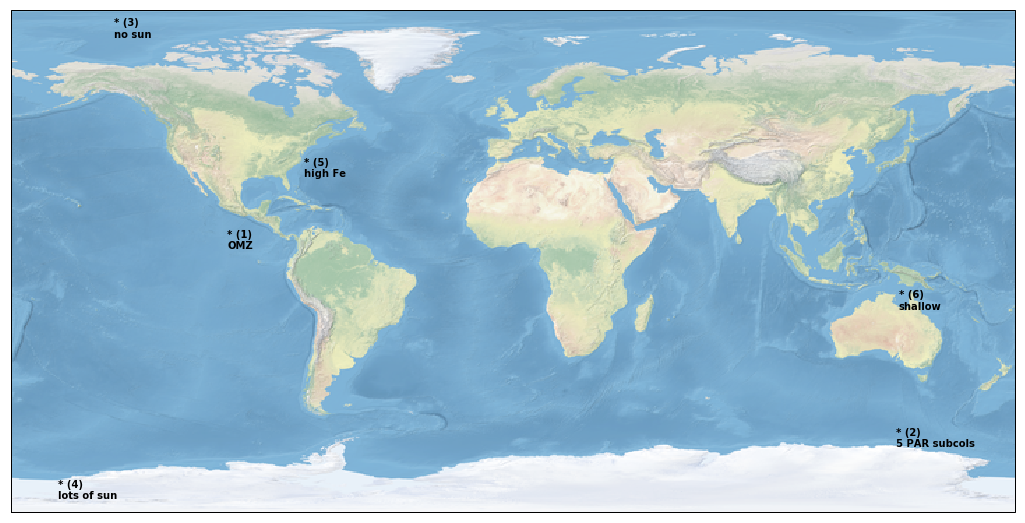

In [3]:
import os

# gx1v7 output; daily averages
filename = os.path.join(os.path.expanduser('~/'), 'MARBL_data', 'POP_hist.nc')
if not os.path.isfile(filename):
    casename='g.e21.G1850ECO.T62_g17.gen_single_col'
    rundir=os.path.join(os.path.sep, 'glade', 'scratch', 'mlevy', casename, 'run')
    date='0001-01'
    filename = os.path.join(rundir, '%s.pop.h.%s.nc' % (casename, date))

if os.path.isfile(filename):
    print("Opening %s" % filename)
    # Workaround for https://github.com/pydata/xarray/issues/1576
    ds_in = xr.open_dataset(filename, decode_cf=False)
    del(ds_in['KMT'].attrs['_FillValue'])
    del(ds_in['KMT'].attrs['missing_value'])
    ds_in = xr.decode_cf(ds_in, decode_times=False, decode_coords=False)
else:
    print("Can not find %s" % filename)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
# ax.coastlines()

active_level_cnt = []
for n, pt in enumerate(grid_pts.keys()):
    lat_in = grid_pts[pt]['lat']
    lon_in = grid_pts[pt]['lon']
    lon = ds_in.isel(time=0, nlat=lat_in, nlon=lon_in)['TLONG'].values
    lat = ds_in.isel(time=0, nlat=lat_in, nlon=lon_in)['TLAT'].values
    active_level_cnt.append(ds_in.isel(time=0, nlat=lat_in, nlon=lon_in)['KMT'].values)

    # Verify location
    label = "* ({})\n{}".format(n+1, pt)
    plt.text(lon, lat, label, horizontalalignment='left', verticalalignment='top', transform=ccrs.Geodetic(), weight='bold')

    print('Column {} ({}):'.format(n+1, pt))
    print('(lon, lat) = ({:.1f}, {:.3f})'.format(lon, lat))
    print('There are {} levels'.format(active_level_cnt[n]))

In [4]:
# Variables to keep (POP Variable Names)
grid_vars = ['TLAT', 'TLONG', 'z_t', 'z_t_150m', 'z_w_bot', 'dz']
forcing_vars = ['ECOSYS_XKW', 'ATM_FINE_DUST_FLUX_CPL', 'ATM_COARSE_DUST_FLUX_CPL', 
                'SEAICE_DUST_FLUX_CPL', 'TEMP', 'SALT', 'ECOSYS_ATM_PRESS', 'FESEDFLUX',
                'ECOSYS_IFRAC', 'IRON_FLUX', 'NOx_FLUX', 'NHy_FLUX', 'ATM_CO2', 'ATM_ALT_CO2']
base_tracers = ['PO4', 'NO3', 'SiO3', 'NH4', 'Fe', 'Lig', 'O2', 'DIC', 'ALK', 'DOC', 'DON', 'DOP', 'DOPr',
                'DONr', 'DOCr', 'zooC', 'spChl', 'spC', 'spP', 'spFe', 'spCaCO3', 'diatChl', 'diatC', 'diatP',
                'diatFe', 'diatSi', 'diazChl', 'diazC', 'diazP', 'diazFe']
alt_co2_tracers = ['DIC', 'ALK']
ciso_tracers = ['DI13C', 'DO13C', 'DI14C', 'DO14C', 'zoo13C', 'zoo14C', 'sp14C', 'sp14C',
                'spCa13CO3', 'spCa14CO3', 'diat13C', 'diat14c', 'diaz13C', 'diaz14C']
# For MCOG_vars, need to determine number of bins
MCOG_vars = []
nbins = len([v for v in ds_in.variables if v.startswith('FRACR_BIN_')])
for n in range(0,nbins):
    for varname in ['FRACR_BIN', 'QSW_BIN']:
        MCOG_vars.append('{}_{:02d}'.format(varname, n+1))

vars_to_keep = grid_vars + forcing_vars + base_tracers + ciso_tracers + MCOG_vars

# Set up separate data sets for forcing and initial conditions
#forcing_col = raw_data.copy(deep=True)
#forcing_col.drop([v for v in raw_data.variables if v not in grid_vars + forcing_vars])

In [5]:
# Reduce data
raw_data_list = []
for n, pt in enumerate(grid_pts.keys()):
    lat_in = grid_pts[pt]['lat']
    lon_in = grid_pts[pt]['lon']
    raw_data_list.append(ds_in.isel(time=0, nlat=lat_in, nlon=lon_in).drop([v for v in ds_in.variables if v not in vars_to_keep]))
    FillVal_r8 = ds_in['TLAT'].encoding['_FillValue']
    for var_name in raw_data_list[n].variables:
        if 'coordinates' in raw_data_list[n][var_name].attrs:
            del(raw_data_list[n][var_name].attrs['coordinates'])
        if raw_data_list[n][var_name].values.dtype == 'float64':
            raw_data_list[n][var_name].encoding['_FillValue'] = FillVal_r8

raw_data = xr.concat(raw_data_list, 'column')
raw_data.to_netcdf('raw_data.nc')

In [6]:
# Variables to keep (MARBL variable names)
hor_grid_vars_to_MARBL = {'lat': 'TLAT', 'lon' : 'TLONG'}
vert_grid_vars_to_MARBL = {'z_t' : 'z_t', 'z_w_bot' : 'z_w_bot', 'delta_z' : 'dz'}
forcing_vars_to_MARBL = {'temperature' : 'TEMP', 'salinity' : 'SALT', 'atm_pressure' : 'ECOSYS_ATM_PRESS',
                         'ice_frac' : 'ECOSYS_IFRAC', 'iron_flux' : 'IRON_FLUX', 'nox_flux' : 'NOx_FLUX', 'nhy_flux' : 'NHy_FLUX',
                         'atm_co2' : 'ATM_CO2', 'atm_alt_co2' : 'ATM_CO2', 'iron_sed_flux' : 'FESEDFLUX'}

MARBL_data = raw_data.copy(deep=True).drop(raw_data.variables)
MARBL_data['active_level_cnt'] = xr.DataArray(active_level_cnt, dims='column')
MARBL_data['active_level_cnt'].attrs['long_name'] = 'Number of active levels'

for MARBL_name, POP_name in hor_grid_vars_to_MARBL.items():
    MARBL_data[MARBL_name] = raw_data[POP_name]
for MARBL_name, POP_name in forcing_vars_to_MARBL.items():
    MARBL_data[MARBL_name] = raw_data[POP_name]
for tracer_name in base_tracers:
    MARBL_data[tracer_name] = raw_data[tracer_name]
    if tracer_name in alt_co2_tracers:
        MARBL_data['{}_ALT_CO2'.format(tracer_name)] = raw_data[tracer_name]

# Define all MARBL_data variables prior to populating
# Metadata will be overwritten, so use ECOSYS_IFRAC for 2D vars
# and TEMP for 3D vars
MARBL_data['u10_sqr'] = raw_data['ECOSYS_IFRAC']
MARBL_data['pressure'] = raw_data['TEMP']

# unit conversion
# cm to m
for varname in vert_grid_vars_to_MARBL:
    iselargs = {'column' : 0} if varname == 'delta_z' else dict()
    MARBL_data[varname] = raw_data[vert_grid_vars_to_MARBL[varname]].isel(**iselargs)
    MARBL_data[varname].values = raw_data[vert_grid_vars_to_MARBL[varname]].isel(**iselargs).values*0.01
    MARBL_data[varname].attrs['units'] = 'm'

# nmol/cm^2/s to mmol/m^2/s
for varname in ['nox_flux', 'nhy_flux']:
    MARBL_data[varname].values = raw_data[forcing_vars_to_MARBL[varname]].values*0.01
    MARBL_data[varname].attrs['units'] = 'mmol/m^2/s'

# salinity units should be psu
MARBL_data['salinity'].attrs['units'] = 'psu'

# Add SST SSS to dataset
MARBL_data['SST'] = physics.get_surface_value(MARBL_data['temperature'])
MARBL_data['SSS'] = physics.get_surface_value(MARBL_data['salinity'])

# u10_sqr
varname = 'u10_sqr'
# first just populate it with ECOSYS_XKW (another scalar) to get all metadata
MARBL_data[varname].values = physics.xkw_to_u10sqr(raw_data['ECOSYS_XKW'].values)
MARBL_data[varname].attrs['long_name'] = '10m wind speed squared'
MARBL_data[varname].attrs['units'] = 'm^2/s^2'

# pressure
varname = 'pressure'
# first just populate it with TEMP (another 1D var) to get all metadata
MARBL_data[varname].values = np.where(np.isnan(raw_data['TEMP'].values),
                                      np.nan,
                                      physics.depth_to_pressure(MARBL_data['z_t'].values))
MARBL_data[varname].attrs['long_name'] = 'Pressure'
MARBL_data[varname].attrs['units'] = 'bars'
FRACR_array = np.empty([ncol, nbins])
QSW_array = np.empty([ncol, nbins])
for col_id in range(ncol):
    for bin_id in range(0,nbins):
        FRACR_array[col_id, bin_id] = raw_data['FRACR_BIN_{:02d}'.format(bin_id+1)].isel(column=col_id).values
        QSW_array[col_id, bin_id] = raw_data['QSW_BIN_{:02d}'.format(bin_id+1)].isel(column=col_id).values
# Combine MCOG bin data into single variable
#MCOG_ds = xr.Dataset({'FRACR_BIN': ('nbin', FRACR_array), 'QSW_BIN': ('nbin', QSW_array)})
MARBL_data['FRACR_BIN'] = xr.DataArray(FRACR_array, dims=['column', 'nbin'])
MARBL_data['QSW_BIN'] = xr.DataArray(QSW_array, dims=['column', 'nbin'])

# dust flux is sum of atm fine dust, atm coarse dust, and seaice dust fluxes
varname = 'dust_flux'
MARBL_data[varname] = raw_data['ATM_FINE_DUST_FLUX_CPL'] + raw_data['ATM_COARSE_DUST_FLUX_CPL'] + \
                          raw_data['SEAICE_DUST_FLUX_CPL']
MARBL_data[varname].attrs = raw_data['ATM_FINE_DUST_FLUX_CPL'].attrs
MARBL_data[varname].attrs['long_name'] = 'Dust Flux'
# convert to kg/m^2/s
MARBL_data[varname].values = MARBL_data[varname].values*10.
MARBL_data[varname].attrs['units'] = 'kg/m^2/s'

MARBL_data.rename({'z_t' : 'zt', 'z_w_bot' : 'zw'}, inplace=True)

for var_name in MARBL_data.variables:
    if MARBL_data[var_name].values.dtype == 'float64':
        MARBL_data[var_name].encoding['_FillValue'] = FillVal_r8

MARBL_data.to_netcdf('marbl.nc')

In [7]:
def set_title(col_id, desc, lat, lon):
    lat_str = '{:.2f}'.format(abs(lat))
    if lat < 0:
        lat_str = '{} S'.format(lat_str)
    elif lat > 0:
        lat_str = '{} N'.format(lat_str)
    lon_str = '{:.2f}'.format(abs(lon))
    if lon < 0:
        lon_str = '{} W'.format(lon_str)
    elif lon > 0:
        lon_str = '{} E'.format(lon_str)
    return('Column {} -- {}: ({}, {})'.format(col_id+1, desc, lat_str, lon_str))

def update_xlim_and_xlabel(interior_forcing):
    if interior_forcing == 'temperature':
        plt.xlim(-2, 30)
    elif interior_forcing == 'salinity':
        plt.xlim(34, 36)
    elif interior_forcing == 'pressure':
        plt.xlim(0,400)
    else:
        raise ValueError("Can not set xlim for '{}'".format(interior_forcing))
    plt.xlabel(interior_forcing)

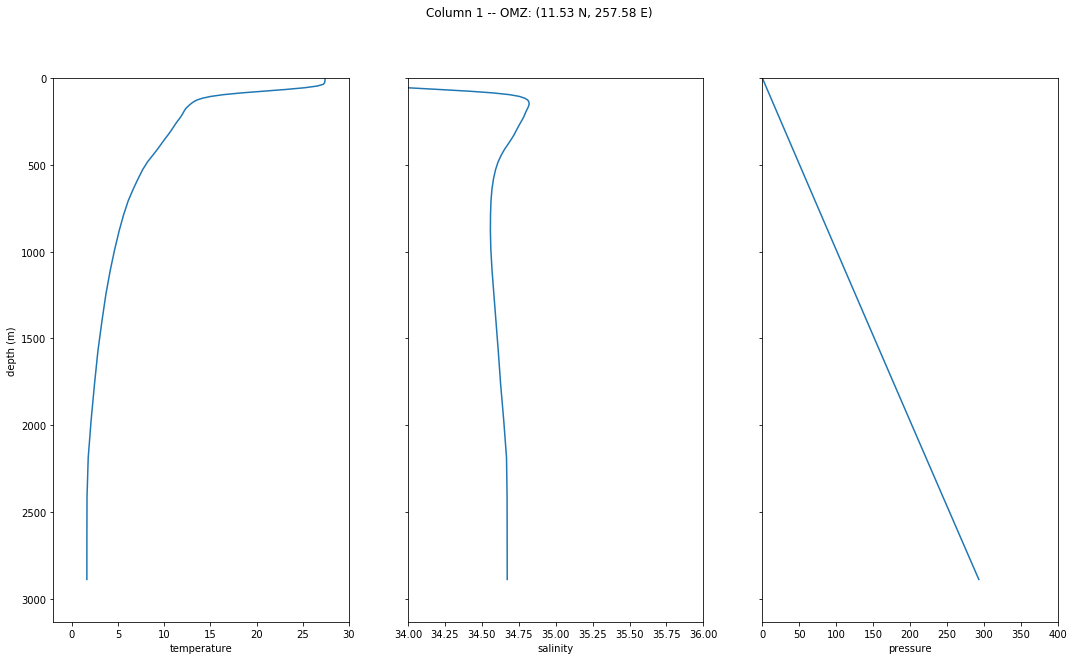

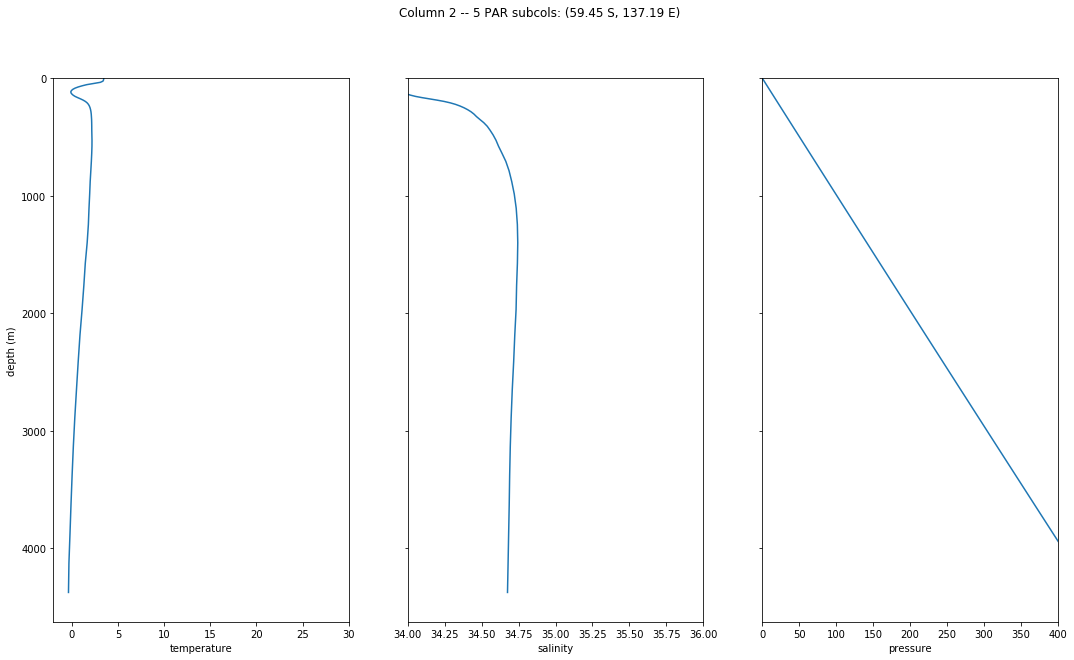

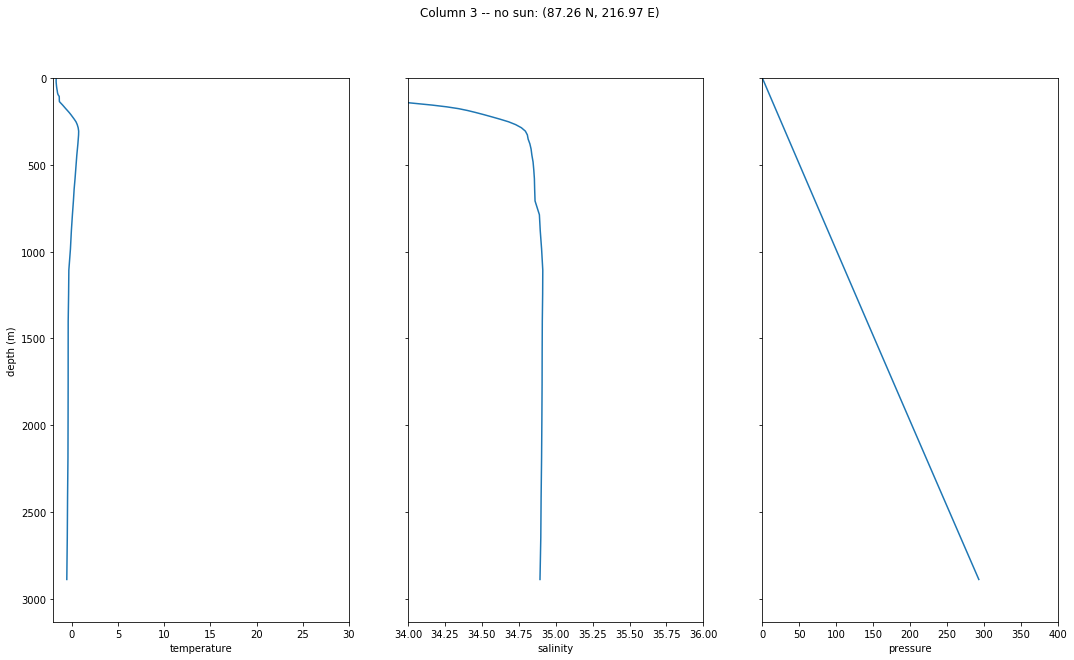

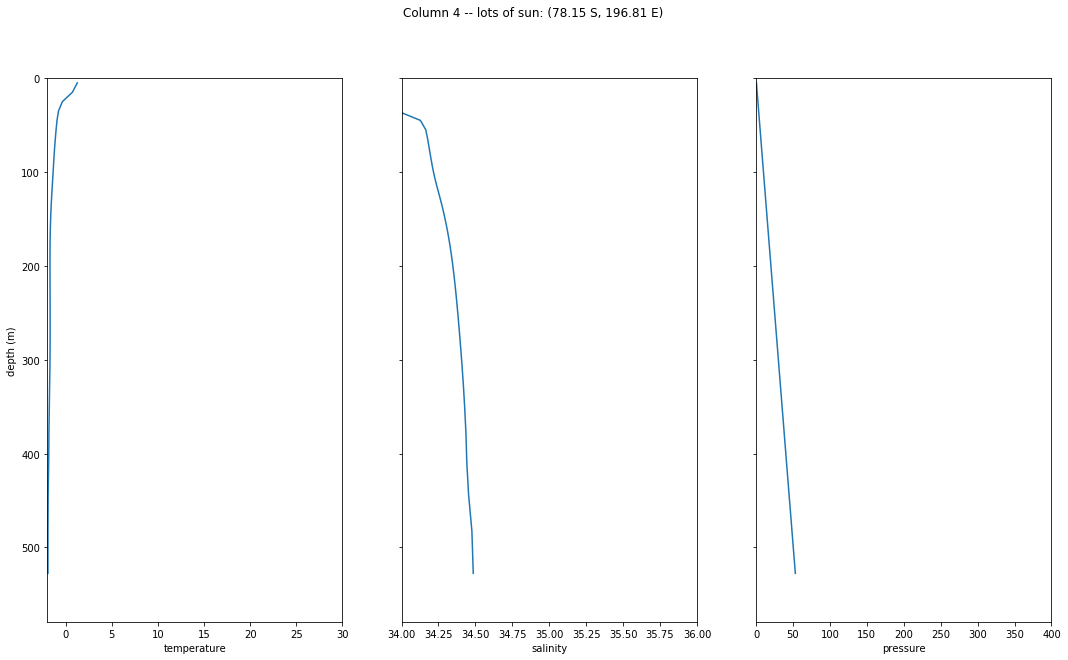

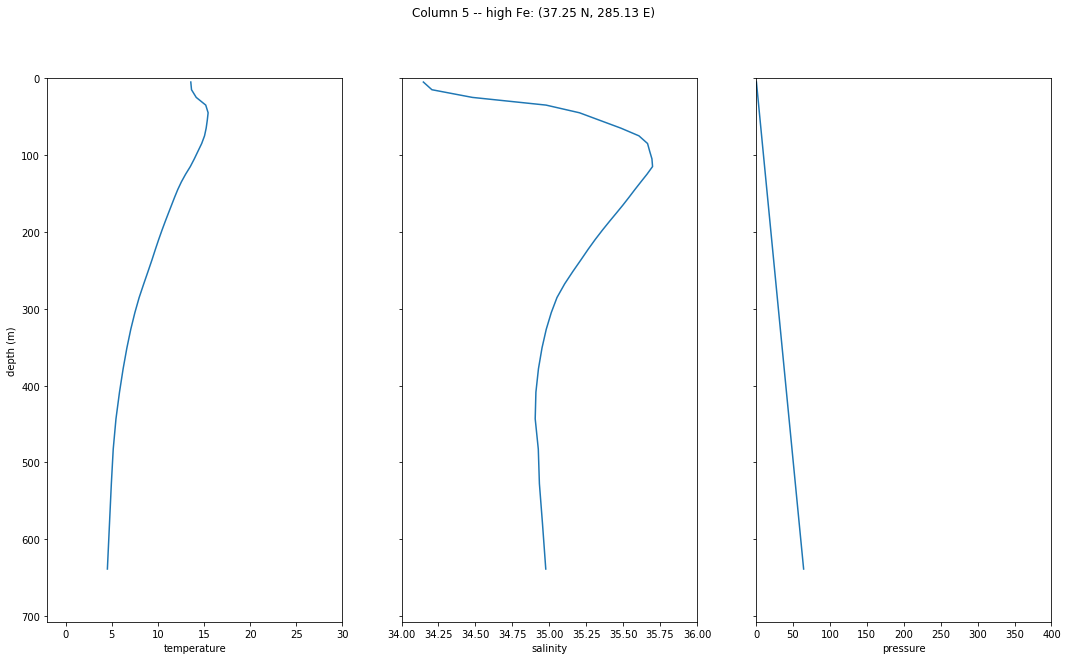

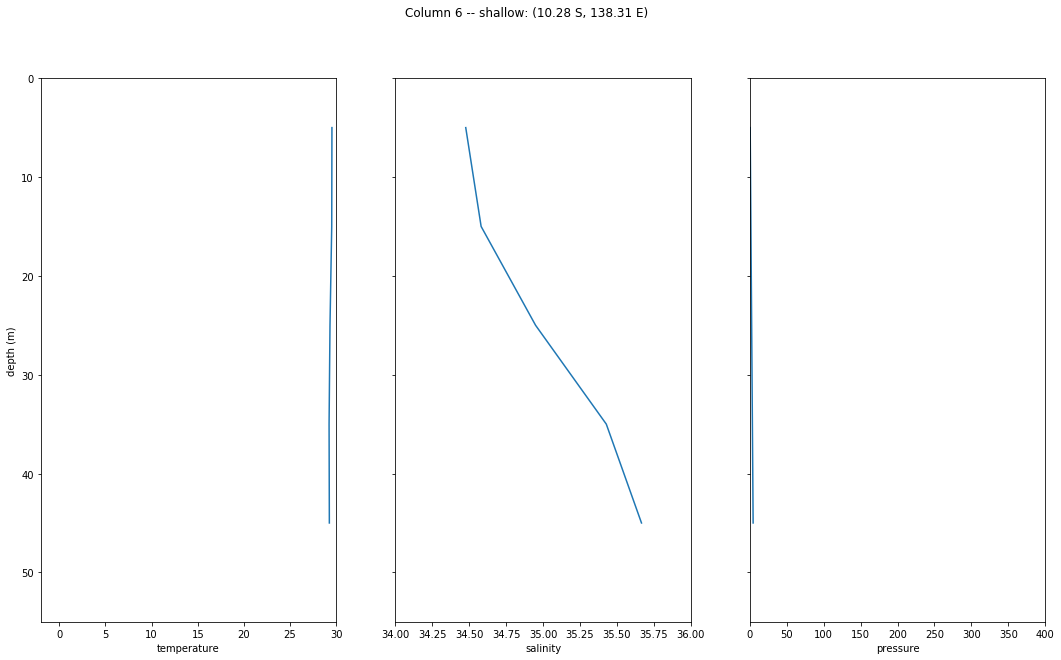

In [8]:
vars_to_plot = ['temperature', 'salinity', 'pressure']
nvars = len(vars_to_plot)

for col_id, pts in enumerate(grid_pts.keys()):
    fig, axes = plt.subplots(ncols=nvars)
    fig.suptitle(set_title(col_id, pts, MARBL_data['lat'].isel(column=col_id).values, MARBL_data['lon'].isel(column=col_id).values))
    plt.xlim(400000,0)

    for n, interior_forcing in enumerate(vars_to_plot):
        MARBL_data[interior_forcing].plot(ax=axes[n])
        plt.subplot(1,nvars,n+1);
        plt.plot(MARBL_data[interior_forcing].isel(column=col_id).values, MARBL_data['zt'].values);
        plt.ylim(MARBL_data['zt'].values[MARBL_data['active_level_cnt'].values[col_id]], 0);
        # Only want y-axis label and tick labels on left-most plot
        plt.ylabel("depth (m)" if (n == 0) else "")
        plt.tick_params(labelleft=(n == 0))
        update_xlim_and_xlabel(interior_forcing);